# Lab 3
## Beamforming

# Part 1 
Here initially study narrowband beamforming and how investigate how different parameters influence the output of the beamformer. We build a class which will implement the beamformer to a narrowband signal which will be used as our base class in which we will be able to compare this against our later study in this lab. Our class assumes a Uniform Linear Array (ULA) with angles in radians and spacing in wavelengths.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
class NarrowbandBeamformer:
    def __init__(self, n_elements, d=0.5, wavelength=1.0, window="rect"):
        self.N = n_elements
        self.d = d
        self.wavelength = wavelength
        self.k = 2*np.pi / self.wavelength
        self.n = np.arange(self.N)

        self.window = self._make_window(window)
        self.theta_steer = 0.0
        self.w = None
        self.steer_convent(self.theta_steer)

    def _make_window(self,window):
        if isinstance(window,str):
            wtype = window.lower()
            if wtype == "rect":
                w = np.ones(self.N)
            elif wtype == "hann":
                w = np.hanning(self.N)
            elif wtype == "hamming":
                w = np.hamming(self.N)
            else:
                raise ValueError(f"Unknown Window type")    
        else:
            w = np.asarray(window)
            if w.shape[0] != self.N:
                raise ValueError(f"Window must have the correct length")
        return w/np.max(np.abs(w))
    def update_weights(self):
        a = self.steering_vector(self.theta_steer)  
        self.w = self.window * a
    def steering_vector(self, theta):
        theta = np.asarray(theta)
        phase = self.k*self.d*np.outer(self.n, np.sin(theta))
        a = np.exp(1j*phase)
        if a.ndim == 2 and a.shape[1] == 1:
            a = a[:, 0]
        return a   
    def steer_convent(self, theta):
        self.theta_steer = theta
        self.update_weights()
    def beamform(self, X):
        X = np.asarray(X)
        if X.shape[0] == self.N:      # (N, T)
            return np.conj(self.w) @ X
        elif X.shape[-1] == self.N:   # (T, N)
            return X @ np.conj(self.w)
        else:
            raise ValueError(f"X must have N={self.N} as first or last dim, got {X.shape}")

    def beampattern(self, theta_grid):
        theta_grid = np.asarray(theta_grid)
        a = self.steering_vector(theta_grid)
        B = np.conj(self.w)@a
        P = np.abs(B)**2

        P/=np.max(P)
        P = 10*np.log10(np.maximum(P,1e-12))
        return P
    def doa_scan(self, X, theta_scan):
        X = np.asarray(X)
        theta_scan = np.asarray(theta_scan)
        metric = np.zeros_like(theta_scan)
        for i, th in enumerate(theta_scan):
            self.steer_convent(th)
            y = self.beamform(X)
            metric[i] = np.var(y)
        theta_hat = theta_scan[np.argmax(metric)]
        return theta_hat, metric
    






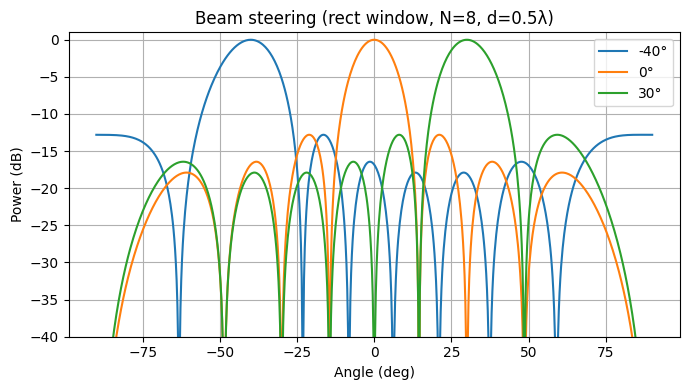

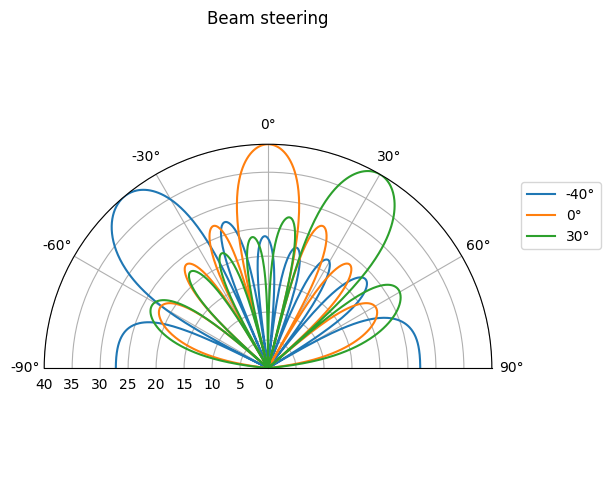

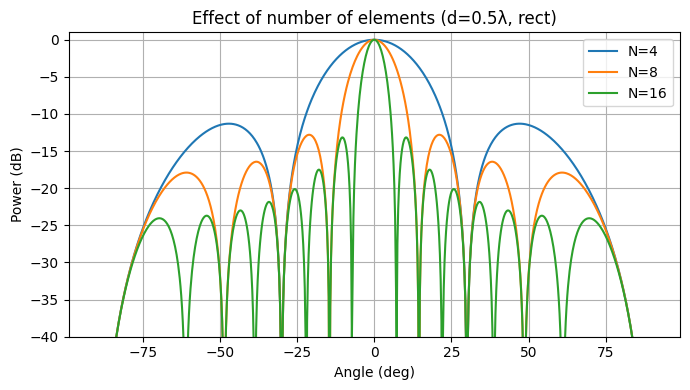

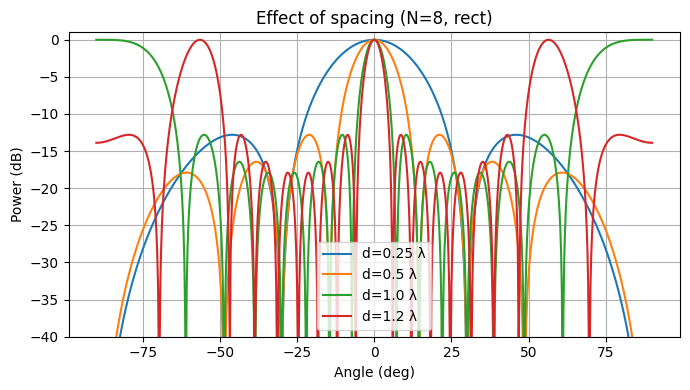

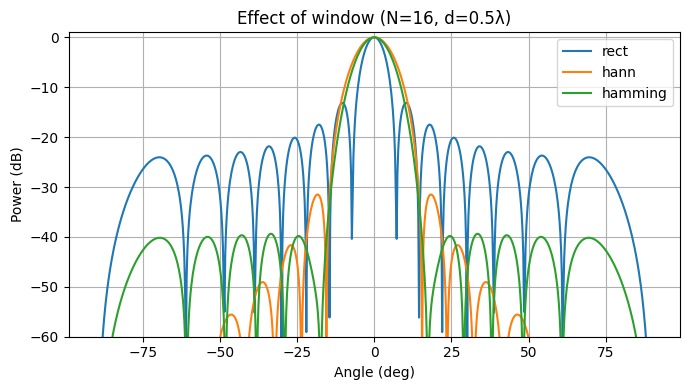

In [37]:

theta_grid = np.linspace(-np.pi/2, np.pi/2, 721)


bf = NarrowbandBeamformer(n_elements=8, d=0.5, window="rect")
steer_angles_deg = [-40, 0, 30]

plt.figure(figsize=(7, 4))
for th_deg in steer_angles_deg:
    bf.steer_convent(theta=np.deg2rad(th_deg))
    P = bf.beampattern(theta_grid) 
    plt.plot(np.rad2deg(theta_grid), P, label=f"{th_deg}°")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Beam steering (rect window, N=8, d=0.5λ)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()
plt.tight_layout()

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 5))
for th_deg in steer_angles_deg:
    bf.steer_convent(theta=np.deg2rad(th_deg))
    P = bf.beampattern(theta_grid)  
    P_clip = np.clip(P, -40, 0)
    r = P_clip + 40
    ax.plot(theta_grid, r, label=f"{th_deg}°")

ax.set_theta_zero_location("N")   
ax.set_theta_direction(-1)     
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_rmax(40)
ax.set_title("Beam steering")

ax.legend(loc="lower left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()


plt.figure(figsize=(7, 4))
for N in [4, 8, 16]:
    bfN = NarrowbandBeamformer(n_elements=N, d=0.5, window="rect")
    bfN.steer_convent(theta=0.0)  
    P = bfN.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=f"N={N}")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of number of elements (d=0.5λ, rect)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()
plt.tight_layout()


plt.figure(figsize=(7, 4))
for d in [0.25, 0.5, 1.0, 1.2]:
    bf_d = NarrowbandBeamformer(n_elements=8, d=d, window="rect")
    bf_d.steer_convent(theta=0.0)
    P = bf_d.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=f"d={d} λ")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of spacing (N=8, rect)")
plt.ylim([-40, 1])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.figure(figsize=(7, 4))
windows = ["rect", "hann", "hamming"]
for win in windows:
    bf_w = NarrowbandBeamformer(n_elements=16, d=0.5, window=win)
    bf_w.steer_convent(theta=0.0)
    P = bf_w.beampattern(theta_grid)
    plt.plot(np.rad2deg(theta_grid), P, label=win)
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("Effect of window (N=16, d=0.5λ)")
plt.ylim([-60, 1])
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()